## $\chi^{2}$ distribution

Let $Z_{1}, Z_{2}, ..., Z_{k}$ be independent, standard normal random variables.

The sum of their squares:

$Q = \sum\limits_{i=1}^{k} Z^{2}_{i}$

is distributed according to the $\chi^{2}$ distribution with number of degress of freedom $n_{d.o.f.} = k$:

$Q \sim \chi^{2}(k)$

## Pearson $\chi^{2}$ test

The sum of relative deviations given:
- our observations of data $\mathbf{n_{data}}$ (Gaussian distributed in each bin)
- the predicted values $\mathbf{n_{pred}}(\theta)$ ($\theta$ being the parameters of our model)
- and their uncertainty $\mathbf{\sigma}$

is:

$S = \sum\limits_{i=1}^{n} \frac{ ( n_{i,data} - n_{i,pred} (\theta) )^{2} }{ \sigma^{2}_{i}}$

Let's denote $S_{min}$ as the minimum of $S$ achivable by varying $\mathbf{\theta}$.

**Statement:**

$S_{min}$ is distributed as $\chi^{2}$ with $n_{d.o.f} = n_{data} - n_{\theta}$.

**Objective of this notebook:**

is to show validity of the above statement through an example.

## References:

- https://en.wikipedia.org/wiki/Chi-squared_distribution
- https://www.pp.rhul.ac.uk/~cowan/stat/stat_3.pdf
- https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test

In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import ncx2
from scipy.optimize import minimize
%matplotlib inline

## Demonstrating minimization procedure <br/> (`scipy.optimize.minimize`)

To demonstrate that the minimzation procedure indeed works we'll take a simple quadratic function and try to find its minimum.

Defining the parabola

In [2]:
def parabola(x):
    y = (x-2.0)**2.0 + 1
    return y

In [3]:
x = np.linspace(-5.0, 5.0, 100)
y = parabola(x)

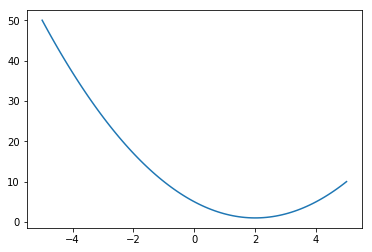

In [4]:
plt.plot(x,y);

Perform minimzation with default settings

In [5]:
m = minimize(parabola, [3])

Results of the minimization

In [6]:
def display_minimization_result(m):
    print("m['success']: ", m['success'])
    print("m['fun']:     ",     m['fun'])
    print("m['x']:       ",       m['x'])

In [7]:
display_minimization_result(m)

m['success']:  True
m['fun']:      1.0
m['x']:        [ 1.99999999]


## Minimization of the sum of relative squared deviations

In [8]:
data = {}

### Domain

In [9]:
nspacing = 20
x = np.linspace(0.0, 5.0, nspacing)
data['x'] = x

### True signal (straigth line)

Parameters

In [10]:
a = 2.4
b = 1.1

In [11]:
signal = a*x + b

### Noise (Gaussian)

Parameters

In [12]:
mean = 0.0
std  = 0.3

In [13]:
noise = np.random.normal(mean, std, nspacing)

## Data = True signal + noise

In [14]:
data['y']   = signal + noise
data['err'] = std

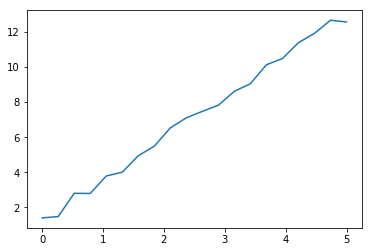

In [15]:
plt.plot(x, data['y']);

## Generate data

In [16]:
def generate_data(a, b, noise_mean, noise_std):
    x  = np.linspace(0.0, 5.0, nspacing)
    signal = a*x + b
    noise = np.random.normal(noise_mean, noise_std, nspacing)
    data['x'] = x
    data['y'] = signal + noise
    data['err'] = noise_std
    return data

## Our data model

In [17]:
def data_model(x, a, b):
    y = a*x + b
    return y

### Test

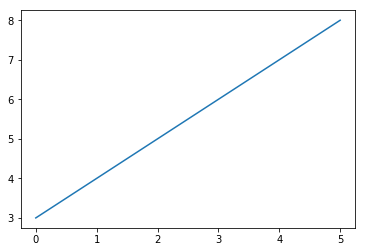

In [18]:
y_model = data_model(x, a=1.0, b=3.0);
plt.plot(x, y_model);

## Constructing the sum of relative squared deviations

In [19]:
def sum_of_rel_deviation(y_obs, y_predicted, error):
    """Simple function to calculate the sum of the relative squared deviations."""
    rel_deviation = (y_obs-y_predicted)**2/error**2
    S = np.sum(rel_deviation)
    return S

In [20]:
sum_of_rel_deviation(data['y'], y_model, error=1.0) 

139.37008420087975

In [21]:
def calc_sum_of_rel_deviation_for_model(model_params, model, data ):
    """Get the sum of relative deviations for a particular realization
       of data given the model."""
    y_predicted = model(data['x'], *model_params)
    S = sum_of_rel_deviation(data['y'], y_predicted, data['err'])
    return S

In [22]:
data = generate_data(a=1.5, b=3.5, noise_mean=0.0, noise_std=0.3)

Initial guesses for the parameters:

In [23]:
initial_guess_a = 5.0
initial_guess_b = 3.0

In [24]:
m = minimize(calc_sum_of_rel_deviation_for_model, [initial_guess_a, initial_guess_b], method = 'Nelder-Mead', args=(data_model,data))

In [25]:
display_minimization_result(m)

m['success']:  True
m['fun']:      2.6475020801
m['x']:        [ 1.55574703  3.40341864]


In [26]:
a = 1.0
b = 3.0
noise_mean = 0.0
noise_std  = 0.3

In [27]:
initial_guess_a = 5.0
initial_guess_b = 3.0

To be able to get an ensemble of $S_{min}$ we write a function which generates a dataset consisting of a sample with different noise for each call, and returns the minimum just like above:

In [28]:
def get_min_sum_of_rel_deviation():
    """Get the minimum of the sum of relative deviations."""
    data = generate_data(a, b, noise_mean, noise_std)
    m = minimize(calc_sum_of_rel_deviation_for_model, [initial_guess_a, initial_guess_b], method = 'Nelder-Mead', args=(data_model,data))
    return m['fun']

In [29]:
get_min_sum_of_rel_deviation()

14.60242253763092

Generate an ensemble of $S_{min}$:

In [30]:
S_min_ensemble = [get_min_sum_of_rel_deviation() for i in range(10000)]

In [31]:
S_x = np.linspace(0.0, 100.0, 200)
S_y17dof = chi2.pdf(S_x, 17)
S_y18dof = chi2.pdf(S_x, 18)
S_y19dof = chi2.pdf(S_x, 19)
S_y20dof = chi2.pdf(S_x, 20)

Notice that it is $\chi^{2}(n_{d.o.f.} = 18)$ which follows the distribution of $S_{min}$ the closest.

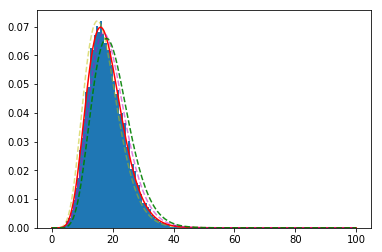

In [34]:
plt.hist(S_min_ensemble, bins=70, normed=True, histtype="stepfilled");
plt.plot(S_x, S_y17dof, c='y', linestyle='--', alpha=0.5);
plt.plot(S_x, S_y18dof, c='r');
plt.plot(S_x, S_y19dof, c='m', linestyle='--', alpha=0.5);
plt.plot(S_x, S_y20dof, c='g', linestyle='--', alpha=0.9);